Numerous contextual models and data configurations for classification of TDT data. The best models are compared in `tdt-comparison.ipynb`.

In [1]:
# Set the file paths here
tdt_train_fn = '/content/tdt-sentiment-151020-train-clean.tsv'
tdt_eval_fn = '/content/tdt-sentiment-151020-dev.tsv'
tdt_unannotated_full_train_fn = '/content/tdt-train-texts.tsv'
tdt_unannotated_full_eval_fn = '/content/tdt-dev-texts.tsv'

In [ ]:
!pip install transformers

In [ ]:
# Choose model and set up input

from transformers import BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
from itertools import groupby
import tensorflow as tf

def transpose(l):
  return [list(t) for t in zip(*l)]

def load_fields(fn):
  return transpose([l.rstrip('\n').split('\t') for l in open(fn).readlines()])

train_id, train_texts, train_labels_raw = load_fields(tdt_train_fn)[:3]
eval_id, eval_texts, eval_labels_raw = load_fields(tdt_eval_fn)[:3]

group_train_id, group_train_texts = load_fields(tdt_unannotated_full_train_fn)[:2]
group_eval_id, group_eval_texts = load_fields(tdt_unannotated_full_eval_fn)[:2]

label_encoder = LabelEncoder()
label_encoder.fit(train_labels_raw)
train_labels = label_encoder.transform(train_labels_raw).tolist()
eval_labels = label_encoder.transform(eval_labels_raw).tolist()
num_labels = len(label_encoder.classes_)

model_name = "TurkuNLP/bert-base-finnish-cased-v1"
#model_name = "TurkuNLP/bert-base-finnish-uncased-v1"

tokenizer = BertTokenizerFast.from_pretrained(model_name, additional_special_tokens=['[unused0]', '[unused1]'])

train_encodings = list(zip([s.split('.', 1)[0] for s in group_train_id], tokenizer(group_train_texts, add_special_tokens=False)['input_ids']))
eval_encodings = list(zip([s.split('.', 1)[0] for s in group_eval_id], tokenizer(group_eval_texts, add_special_tokens=False)['input_ids']))

input_size = 256

def add_context(ids, labels, encodings, input_size):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    sentence_size = min(len(group[i]), input_size-4)
    context_size = input_size-4-sentence_size
    if i > 0:
      prev_sentence = group[i-1]
    else:
      prev_sentence = []
    if i < len(group)-1:
      fol_sentence = group[i+1]
    else:
      fol_sentence = []
    prev_sentence = prev_sentence[len(prev_sentence) - max(context_size//2, context_size-len(fol_sentence)):]
    fol_sentence = fol_sentence[:context_size-len(prev_sentence)]
    input = [tokenizer.cls_token_id] + prev_sentence + [tokenizer.additional_special_tokens_ids[0]] + group[i][:sentence_size] + [tokenizer.additional_special_tokens_ids[1]] + fol_sentence + [tokenizer.sep_token_id]
    mask = [0] + [0]*len(prev_sentence) + [1] + [0]*sentence_size + [1] + [0]*len(fol_sentence) + [0]
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

train_context = add_context(train_id, train_labels, train_encodings, input_size)
eval_context = add_context(eval_id, eval_labels, eval_encodings, input_size)

def pad(l, size):
  return [s + [0]*(size - len(s)) for s in l]

train_attention_mask = pad([[1]*len(s) for s in train_context[0]], input_size)
train_input = pad(train_context[0], input_size)
train_mask = pad(train_context[1], input_size)
eval_attention_mask = pad([[1]*len(s) for s in eval_context[0]], input_size)
eval_input = pad(eval_context[0], input_size)
eval_mask = pad(eval_context[1], input_size)

In [10]:
print(tokenizer.additional_special_tokens_ids)

print(train_texts[:5])
print(train_attention_mask[:5])
print(train_input[:5])
print([tokenizer.convert_ids_to_tokens(l) for l in train_input[:5]])
print(train_mask[:5])

print(len(train_input))
print(len(eval_input))

[1, 2]
['Kävelyreitti III', 'Jäällä kävely avaa aina hauskoja ja erikoisia näkökulmia kaupunkiin .', 'Kuinka erilaiselta maailma sieltä näyttikään .', 'Vaikka tiesi , millainen Turku on kartalla , se hämmästytti siltikin .', 'Kävelyreitti II']
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Train mean: 54.26111156585086, Train stdev: 30.482012233927914
Validation mean: 53.96041055718475, Validation stdev: 29.622996018069724


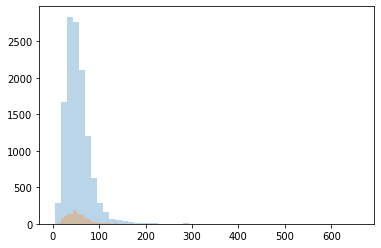

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Histogram of group lengths as wordpieces

def context_lengths(encodings):
  padded_groups = [[0] + [len(v) for _, v in list(g)] + [0] for _, g in groupby(encodings, lambda x: x[0])]
  return [g[i-1]+g[i]+g[i+1] for g in padded_groups for i in range(1, len(g)-1)]

train_lengths = context_lengths(train_encodings)
eval_lengths = context_lengths(eval_encodings)

print(f'Train mean: {np.mean(train_lengths)}, Train stdev: {np.std(train_lengths)}')
print(f'Validation mean: {np.mean(eval_lengths)}, Validation stdev: {np.std(eval_lengths)}')

kwargs = dict(histtype='stepfilled', bins=50, alpha=0.3)
plt.hist(train_lengths, **kwargs)
plt.hist(eval_lengths, **kwargs)
plt.show()

In [12]:
# Set up training
from transformers import TFBertForSequenceClassification, optimization_tf

class ReturnBestEarlyStopping(tf.keras.callbacks.EarlyStopping):
  def __init__(self, **kwargs):
    super(ReturnBestEarlyStopping, self).__init__(**kwargs)
  
  def on_train_end(self, logs=None):
    if self.restore_best_weights:
      self.model.set_weights(self.best_weights)

init_lr = 2e-5

epochs = 3
batch_size_train = 16
batch_size_eval = 16

def train(model, t, train_labels, eval):
  size_train = len(train_labels)
  steps_per_epoch = int(size_train/batch_size_train)
  steps_train = steps_per_epoch*epochs
  steps_warmup = int(epochs * size_train * 0.1 / batch_size_train)
  optimizer, _ = optimization_tf.create_optimizer(init_lr=init_lr,
                                                  num_train_steps=steps_train,
                                                  num_warmup_steps=steps_warmup,
                                                  weight_decay_rate=0.01)
  model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['sparse_categorical_accuracy'])
  history = model.fit(t,
                      train_labels,
                      validation_data=eval,
                      batch_size=batch_size_train,
                      epochs=epochs,
                      callbacks=[ReturnBestEarlyStopping(monitor='val_sparse_categorical_accuracy', patience=2, restore_best_weights=True)])
  return model

In [13]:
# Set up evaluation

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def train_evaluate(train_x, train_y, eval_x, eval_y, num_labels, run_count):
  runs = []
  for i in range(run_count):
    bert = TFBertForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=num_labels)
    bert = train(bert, train_x, train_y, (eval_x, eval_y))
    runs.append(bert.predict(eval_x)[0])
  return runs

def format_floats(l):
  return ', '.join(f'{x:.4f}' for x in l)

def print_results(runs, eval_labels):
  accuracy = [accuracy_score(eval_labels, p.argmax(-1)) for p in runs]
  weighted_f1 = [f1_score(eval_labels, p.argmax(-1), average='weighted') for p in runs]
  print(f"Accuracy: {format_floats(accuracy)}")
  print(f"Weighted F-score: {format_floats(weighted_f1)}")
  print(f'Average accuracy: {np.mean(accuracy):.4f}, stdev: {np.std(accuracy):.4f}')
  print(f'Average weighted F-score: {np.mean(weighted_f1):.4f}, stdev: {np.std(weighted_f1):.4f}')
  max_i = accuracy.index(max(accuracy))
  max_p = runs[max_i].argmax(-1)
  ConfusionMatrixDisplay(confusion_matrix(eval_labels, max_p), label_encoder.classes_).plot()
  print(classification_report(eval_labels, max_p, target_names=label_encoder.classes_, digits=4))

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_189', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 187s 272ms/step - loss: 0.6053 - sparse_categorical_accuracy: 0.7809 - val_loss: 0.3759 - val_sparse_categorical_accuracy: 0.8721
Epoch 2/3
686/686 [==============================] - 184s 269ms/step - loss: 0.2791 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.3321 - val_sparse_categorical_accuracy: 0.8823
Epoch 3/3
686/686 [==============================] - 184s 269ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.3734 - val_sparse_categorical_accuracy: 0.8874


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_227']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 186s 272ms/step - loss: 0.6157 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.3565 - val_sparse_categorical_accuracy: 0.8662
Epoch 2/3
686/686 [==============================] - 184s 268ms/step - loss: 0.2825 - sparse_categorical_accuracy: 0.9052 - val_loss: 0.3272 - val_sparse_categorical_accuracy: 0.8798
Epoch 3/3
686/686 [==============================] - 184s 268ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.9612 - val_loss: 0.3674 - val_sparse_categorical_accuracy: 0.8798


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_265', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 187s 272ms/step - loss: 0.6213 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.3589 - val_sparse_categorical_accuracy: 0.8713
Epoch 2/3
686/686 [==============================] - 184s 268ms/step - loss: 0.2815 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.3151 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/3
686/686 [==============================] - 184s 268ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.9615 - val_loss: 0.3512 - val_sparse_categorical_accuracy: 0.8772


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_303']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 187s 272ms/step - loss: 0.6099 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.3683 - val_sparse_categorical_accuracy: 0.8730
Epoch 2/3
686/686 [==============================] - 184s 268ms/step - loss: 0.2739 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.3143 - val_sparse_categorical_accuracy: 0.8840
Epoch 3/3
686/686 [==============================] - 184s 268ms/step - loss: 0.1177 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.3626 - val_sparse_categorical_accuracy: 0.8755


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_341']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 186s 272ms/step - loss: 0.6104 - sparse_categorical_accuracy: 0.7790 - val_loss: 0.3658 - val_sparse_categorical_accuracy: 0.8696
Epoch 2/3
686/686 [==============================] - 184s 268ms/step - loss: 0.2676 - sparse_categorical_accuracy: 0.9078 - val_loss: 0.3346 - val_sparse_categorical_accuracy: 0.8755
Epoch 3/3
686/686 [==============================] - 184s 268ms/step - loss: 0.1152 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.3646 - val_sparse_categorical_accuracy: 0.8815


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_379']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 187s 272ms/step - loss: 0.5962 - sparse_categorical_accuracy: 0.7907 - val_loss: 0.3997 - val_sparse_categorical_accuracy: 0.8577
Epoch 2/3
686/686 [==============================] - 184s 269ms/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9064 - val_loss: 0.3479 - val_sparse_categorical_accuracy: 0.8764
Epoch 3/3
686/686 [==============================] - 184s 269ms/step - loss: 0.1218 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.3660 - val_sparse_categorical_accuracy: 0.8815


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_417']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 186s 272ms/step - loss: 0.5903 - sparse_categorical_accuracy: 0.7897 - val_loss: 0.3591 - val_sparse_categorical_accuracy: 0.8679
Epoch 2/3
686/686 [==============================] - 184s 269ms/step - loss: 0.2563 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.3435 - val_sparse_categorical_accuracy: 0.8747
Epoch 3/3
686/686 [==============================] - 184s 268ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.3618 - val_sparse_categorical_accuracy: 0.8789
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 64, batch size = 16, epochs = 3
Accuracy: 0.8874, 0.8798, 0.8789, 0.8840, 0.8815, 0.8815, 0.8789
Weighted F-score: 0.8826, 0.8754, 0.8743, 0.8794, 0.8779, 0.8778, 0.8762
Average accuracy: 0.8817, stdev: 0.0029
Average weighted F-score: 0.8777, stdev: 0.0026
              precision    recall  f1-score   support

    negative     0.7857    0.6016    0.6814       

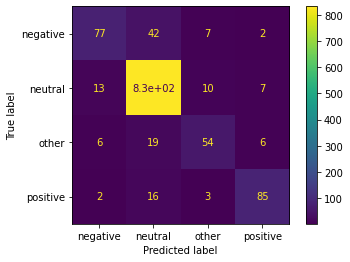

In [ ]:
# Evaluate a model with one sentence of context on both sides of the focus sentence

runs = train_evaluate(tf.constant(train_input), tf.constant(train_labels), tf.constant(eval_input), tf.constant(eval_labels), num_labels, 7)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(runs, eval_labels)

In [ ]:
# Set up a model with as much context as possible around the focus sentence

def add_whole_context(ids, labels, encodings, input_size):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    prev_context = [e for l in group[:i] for e in l]
    fol_context = [e for l in group[i+1:] for e in l]
    sentence_size = min(len(group[i]), input_size-4)
    context_size = input_size-4-sentence_size
    prev_context = prev_context[len(prev_context)-max(context_size-len(fol_context), context_size//2):]
    fol_context = fol_context[:context_size-len(prev_context)]
    input = [tokenizer.cls_token_id] + prev_context + [tokenizer.additional_special_tokens_ids[0]] + group[i][:sentence_size] + [tokenizer.additional_special_tokens_ids[1]] + fol_context + [tokenizer.sep_token_id]
    mask = [0] + [0]*len(prev_context) + [1] + [0]*sentence_size + [1] + [0]*len(fol_context) + [0]
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

whole_train_context = add_whole_context(train_id, train_labels, train_encodings, input_size)
whole_eval_context = add_whole_context(eval_id, eval_labels, eval_encodings, input_size)

whole_train_attention_mask = pad([[1]*len(s) for s in whole_train_context[0]], input_size)
whole_train_input = pad(whole_train_context[0], input_size)
whole_train_mask = pad(whole_train_context[1], input_size)
whole_eval_attention_mask = pad([[1]*len(s) for s in whole_eval_context[0]], input_size)
whole_eval_input = pad(whole_eval_context[0], input_size)
whole_eval_mask = pad(whole_eval_context[1], input_size)

print(whole_train_attention_mask[:5])
print(whole_train_input[:5])
print([tokenizer.convert_ids_to_tokens(l) for l in whole_train_input[:5]])
print(whole_train_mask[:5])
print(whole_eval_attention_mask[:5])
print(whole_eval_input[:5])
print(whole_eval_mask[:5])
print(max([len(t) for t in whole_train_input]))
print(min([len(t) for t in whole_train_input]))

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_151', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 123s 179ms/step - loss: 0.5904 - sparse_categorical_accuracy: 0.7954 - val_loss: 0.3768 - val_sparse_categorical_accuracy: 0.8569
Epoch 2/3
686/686 [==============================] - 119s 173ms/step - loss: 0.2734 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.3124 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/3
686/686 [==============================] - 118s 172ms/step - loss: 0.1202 - sparse_categorical_accuracy: 0.9636 - val_loss: 0.3516 - val_sparse_categorical_accuracy: 0.8747


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_189']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 121s 176ms/step - loss: 0.6032 - sparse_categorical_accuracy: 0.7828 - val_loss: 0.4057 - val_sparse_categorical_accuracy: 0.8459
Epoch 2/3
686/686 [==============================] - 118s 172ms/step - loss: 0.2738 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.3208 - val_sparse_categorical_accuracy: 0.8831
Epoch 3/3
686/686 [==============================] - 117s 171ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9641 - val_loss: 0.3754 - val_sparse_categorical_accuracy: 0.8738


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_227']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 120s 175ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.7950 - val_loss: 0.4752 - val_sparse_categorical_accuracy: 0.8484
Epoch 2/3
686/686 [==============================] - 118s 171ms/step - loss: 0.2867 - sparse_categorical_accuracy: 0.9029 - val_loss: 0.3516 - val_sparse_categorical_accuracy: 0.8764
Epoch 3/3
686/686 [==============================] - 117s 171ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.3649 - val_sparse_categorical_accuracy: 0.8815


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_265']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 119s 174ms/step - loss: 0.5832 - sparse_categorical_accuracy: 0.7975 - val_loss: 0.3832 - val_sparse_categorical_accuracy: 0.8518
Epoch 2/3
686/686 [==============================] - 117s 170ms/step - loss: 0.2808 - sparse_categorical_accuracy: 0.9051 - val_loss: 0.3158 - val_sparse_categorical_accuracy: 0.8815
Epoch 3/3
686/686 [==============================] - 117s 170ms/step - loss: 0.1212 - sparse_categorical_accuracy: 0.9629 - val_loss: 0.3345 - val_sparse_categorical_accuracy: 0.8857


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_303']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 119s 174ms/step - loss: 0.6023 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.3904 - val_sparse_categorical_accuracy: 0.8484
Epoch 2/3
686/686 [==============================] - 116s 170ms/step - loss: 0.2712 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.3446 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/3
686/686 [==============================] - 116s 170ms/step - loss: 0.1201 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.3697 - val_sparse_categorical_accuracy: 0.8874


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_341']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 121s 176ms/step - loss: 0.6074 - sparse_categorical_accuracy: 0.7847 - val_loss: 0.3529 - val_sparse_categorical_accuracy: 0.8679
Epoch 2/3
686/686 [==============================] - 117s 170ms/step - loss: 0.2755 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.3462 - val_sparse_categorical_accuracy: 0.8696
Epoch 3/3
686/686 [==============================] - 117s 171ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.9648 - val_loss: 0.3564 - val_sparse_categorical_accuracy: 0.8831


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_379', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 119s 174ms/step - loss: 0.6113 - sparse_categorical_accuracy: 0.7854 - val_loss: 0.4353 - val_sparse_categorical_accuracy: 0.8442
Epoch 2/3
686/686 [==============================] - 117s 170ms/step - loss: 0.2925 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.3379 - val_sparse_categorical_accuracy: 0.8764
Epoch 3/3
686/686 [==============================] - 117s 171ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9603 - val_loss: 0.3728 - val_sparse_categorical_accuracy: 0.8815


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_417']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 119s 174ms/step - loss: 0.6123 - sparse_categorical_accuracy: 0.7765 - val_loss: 0.4045 - val_sparse_categorical_accuracy: 0.8577
Epoch 2/3
686/686 [==============================] - 117s 170ms/step - loss: 0.2714 - sparse_categorical_accuracy: 0.9056 - val_loss: 0.3302 - val_sparse_categorical_accuracy: 0.8730
Epoch 3/3
686/686 [==============================] - 117s 170ms/step - loss: 0.1216 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.3435 - val_sparse_categorical_accuracy: 0.8781


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_455']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 119s 174ms/step - loss: 0.6134 - sparse_categorical_accuracy: 0.7821 - val_loss: 0.3571 - val_sparse_categorical_accuracy: 0.8603
Epoch 2/3
686/686 [==============================] - 117s 171ms/step - loss: 0.2727 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.3294 - val_sparse_categorical_accuracy: 0.8798
Epoch 3/3
686/686 [==============================] - 116s 169ms/step - loss: 0.1187 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.3529 - val_sparse_categorical_accuracy: 0.8857


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_493']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 120s 175ms/step - loss: 0.6224 - sparse_categorical_accuracy: 0.7740 - val_loss: 0.4087 - val_sparse_categorical_accuracy: 0.8569
Epoch 2/3
686/686 [==============================] - 117s 171ms/step - loss: 0.2882 - sparse_categorical_accuracy: 0.9009 - val_loss: 0.3248 - val_sparse_categorical_accuracy: 0.8798
Epoch 3/3
686/686 [==============================] - 117s 171ms/step - loss: 0.1292 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.3470 - val_sparse_categorical_accuracy: 0.8781
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 64, batch size = 16, epochs = 3
Accuracy: 0.8789, 0.8831, 0.8815, 0.8857, 0.8874, 0.8831, 0.8815, 0.8781, 0.8857, 0.8798
Weighted F-score: 0.8753, 0.8820, 0.8786, 0.8837, 0.8829, 0.8799, 0.8768, 0.8759, 0.8828, 0.8739
Average accuracy: 0.8825, stdev: 0.0030
Average weighted F-score: 0.8792, stdev: 0.0034
              precision    recall  f1-score   support

  

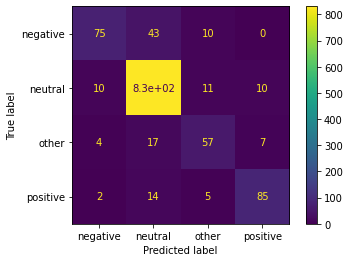

In [ ]:
# Evaluate a model with as much context as possible around the focus sentence

whole_runs = train_evaluate(tf.constant(whole_train_input), tf.constant(train_labels), tf.constant(whole_eval_input), tf.constant(eval_labels), num_labels, 10)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(whole_runs, eval_labels)

In [ ]:
# Set up a model which uses the two context separation tokens for predictions

from transformers import TFBertModel

def sep_token_mean_model(model_name, num_labels):
  bert = TFBertModel.from_pretrained(model_name)

  bert_input = tf.keras.layers.Input(shape=(input_size,), dtype='int32', name='bert')
  mask_input = tf.keras.layers.Input(shape=(input_size,), dtype='float32', name='mask')

  bert_output = bert(bert_input)[0]
  bert_dropout = tf.keras.layers.Dropout(0.1)(bert_output)
  masked_mean = tf.keras.layers.Lambda(
      lambda x: tf.math.reduce_sum(tf.math.multiply(x[0], tf.expand_dims(x[1], -1)), axis=[1])
      / tf.math.reduce_sum(x[1])
      )([bert_dropout, mask_input])

  out = tf.keras.layers.Dense(num_labels, activation='softmax', name='out')(masked_mean)

  model = tf.keras.Model(
      inputs=[bert_input, mask_input],
      outputs=[out]
  )

  return model

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert (InputLayer)               [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 124521984   bert[0][0]                       
__________________________________________________________________________________________________
dropout_797 (Dropout)           (None, 128, 768)     0           tf_bert_model[0][0]              
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 128)]        0                                            
_______________________________________________________________________________________

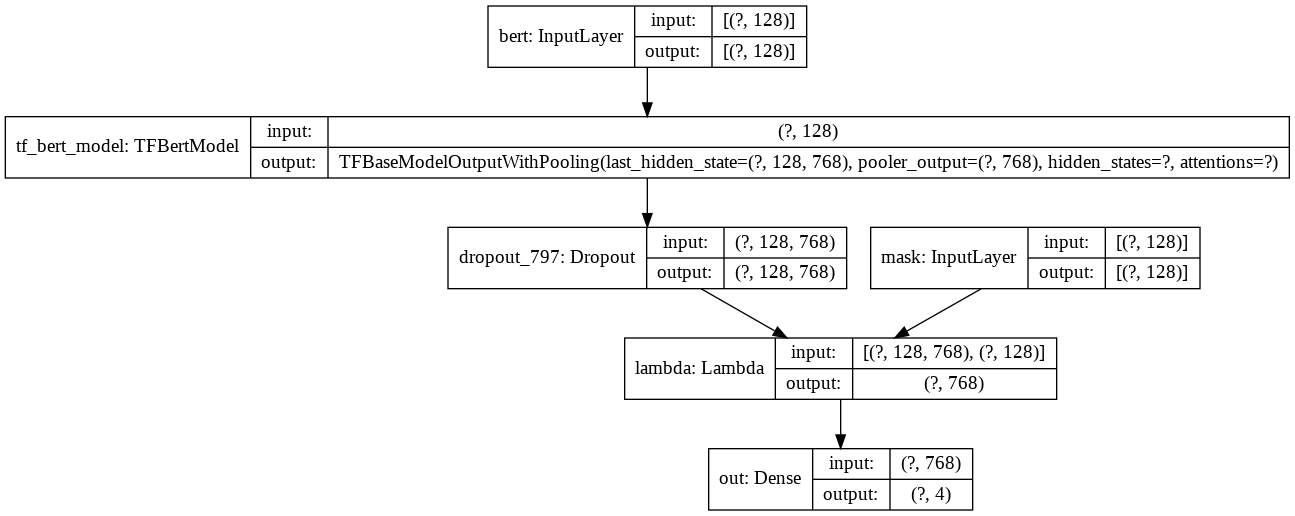

In [ ]:
test_model = sep_token_mean_model(model_name, num_labels)
print(test_model.summary())
tf.keras.utils.plot_model(test_model, show_shapes=True)

In [ ]:
# Set up training and evaluation for custom models

def train_custom(model, t, train_labels, eval):
  size_train = len(train_labels)
  steps_per_epoch = int(size_train/batch_size_train)
  steps_train = steps_per_epoch*epochs
  steps_warmup = int(epochs * size_train * 0.1 / batch_size_train)
  optimizer, _ = optimization_tf.create_optimizer(init_lr=init_lr,
                                                  num_train_steps=steps_train,
                                                  num_warmup_steps=steps_warmup,
                                                  weight_decay_rate=0.01)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  history = model.fit(t,
                      train_labels,
                      validation_data=eval,
                      batch_size=batch_size_train,
                      epochs=epochs,
                      callbacks=[ReturnBestEarlyStopping(monitor='val_sparse_categorical_accuracy', patience=2, restore_best_weights=True)])
  return model

def train_evaluate_custom(generate_model, train_x, train_y, eval_x, eval_y, num_labels, run_count):
  runs = []
  for i in range(run_count):
    model = generate_model(model_name, num_labels)
    model = train_custom(model, train_x, train_y, (eval_x, eval_y))
    runs.append(model.predict(eval_x))
  return runs

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
686/686 [==============================] - 336s 489ms/step - loss: 0.6719 - sparse_categorical_accuracy: 0.7902 - val_loss: 0.4635 - val_sparse_categorical_accuracy: 0.8561
Epoch 2/2
686/686 [==============================] - 335s 488ms/step - loss: 0.3871 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.4111 - val_sparse_categorical_accuracy: 0.8747


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
686/686 [==============================] - 337s 492ms/step - loss: 0.6581 - sparse_categorical_accuracy: 0.7989 - val_loss: 0.4700 - val_sparse_categorical_accuracy: 0.8577
Epoch 2/2
686/686 [==============================] - 335s 489ms/step - loss: 0.3643 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.4005 - val_sparse_categorical_accuracy: 0.8772


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
686/686 [==============================] - 339s 495ms/step - loss: 0.6619 - sparse_categorical_accuracy: 0.7905 - val_loss: 0.4414 - val_sparse_categorical_accuracy: 0.8704
Epoch 2/2
686/686 [==============================] - 336s 490ms/step - loss: 0.3715 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.3967 - val_sparse_categorical_accuracy: 0.8806
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 128, batch size = 16, epochs = 2
Accuracy: 0.8755, 0.8772, 0.8806
Weighted F-score: 0.8683, 0.8738, 0.8751
Average accuracy: 0.8778, stdev: 0.0021
Average weighted F-score: 0.8724, stdev: 0.0029
              precision    recall  f1-score   support

    negative     0.7396    0.5547    0.6339       128
     neutral     0.9111    0.9629    0.9363       862
       other     0.7200    0.6353    0.6750        85
    positive     0.8586    0.8019    0.8293       106

    accuracy                         0.8806      1181
   macro avg     0.8073  

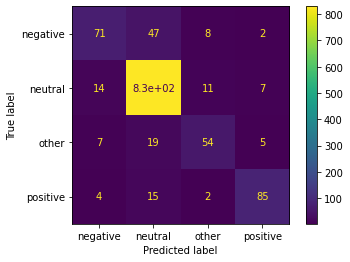

In [ ]:
# Evaluate a model which uses the two context separation tokens for predictions

token_prediction_runs = train_evaluate_custom(
    sep_token_mean_model,
    [tf.constant(whole_train_input), tf.constant(whole_train_mask)],
    tf.constant(train_labels),
    [tf.constant(whole_eval_input), tf.constant(whole_eval_mask)],
    tf.constant(eval_labels),
    num_labels,
    3)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(token_prediction_runs, eval_labels)

In [ ]:
# Set up a model with separate masks for the separation tokens

from transformers import TFBertModel

def mask_first(l):
  masked = [0]*len(l)
  masked[l.index(1)] = 1
  return masked

def mask_last(l):
  return mask_first(l[::-1])[::-1]

prev_train_mask = [mask_first(l) for l in whole_train_mask]
fol_train_mask = [mask_last(l) for l in whole_train_mask]
prev_eval_mask = [mask_first(l) for l in whole_eval_mask]
fol_eval_mask = [mask_last(l) for l in whole_eval_mask]

print(whole_train_mask[:5])
print(prev_train_mask[:5])
print(fol_train_mask[:5])
print(whole_eval_mask[:5])
print(prev_eval_mask[:5])
print(fol_eval_mask[:5])

def sep_token_concat_model(model_name, num_labels):
  bert = TFBertModel.from_pretrained(model_name)

  bert_input = tf.keras.layers.Input(shape=(input_size,), dtype='int32', name='bert')
  prev_mask_input = tf.keras.layers.Input(shape=(input_size,), dtype='float32', name='prev_mask')
  fol_mask_input = tf.keras.layers.Input(shape=(input_size,), dtype='float32', name='fol_mask')

  bert_output = bert(bert_input)[0]
  bert_dropout = tf.keras.layers.Dropout(0.1)(bert_output)
  masked_prev = tf.keras.layers.Lambda(
      lambda x: tf.math.reduce_sum(tf.math.multiply(x[0], tf.expand_dims(x[1], -1)), axis=[1])
      )([bert_dropout, prev_mask_input])
  masked_fol = tf.keras.layers.Lambda(
      lambda x: tf.math.reduce_sum(tf.math.multiply(x[0], tf.expand_dims(x[1], -1)), axis=[1])
      )([bert_dropout, fol_mask_input])
  concatenated = tf.keras.layers.Concatenate()([masked_prev, masked_fol])

  out = tf.keras.layers.Dense(num_labels, activation='softmax', name='out')(concatenated)

  model = tf.keras.Model(
      inputs=[bert_input, prev_mask_input, fol_mask_input],
      outputs=[out]
  )

  return model

[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 1, 0, 0, 0, 0, 0, 0, 0, 

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert (InputLayer)               [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 128, 768), ( 124521984   bert[0][0]                       
__________________________________________________________________________________________________
dropout_75 (Dropout)            (None, 128, 768)     0           tf_bert_model_1[0][0]            
__________________________________________________________________________________________________
prev_mask (InputLayer)          [(None, 128)]        0                                            
_______________________________________________________________________________________

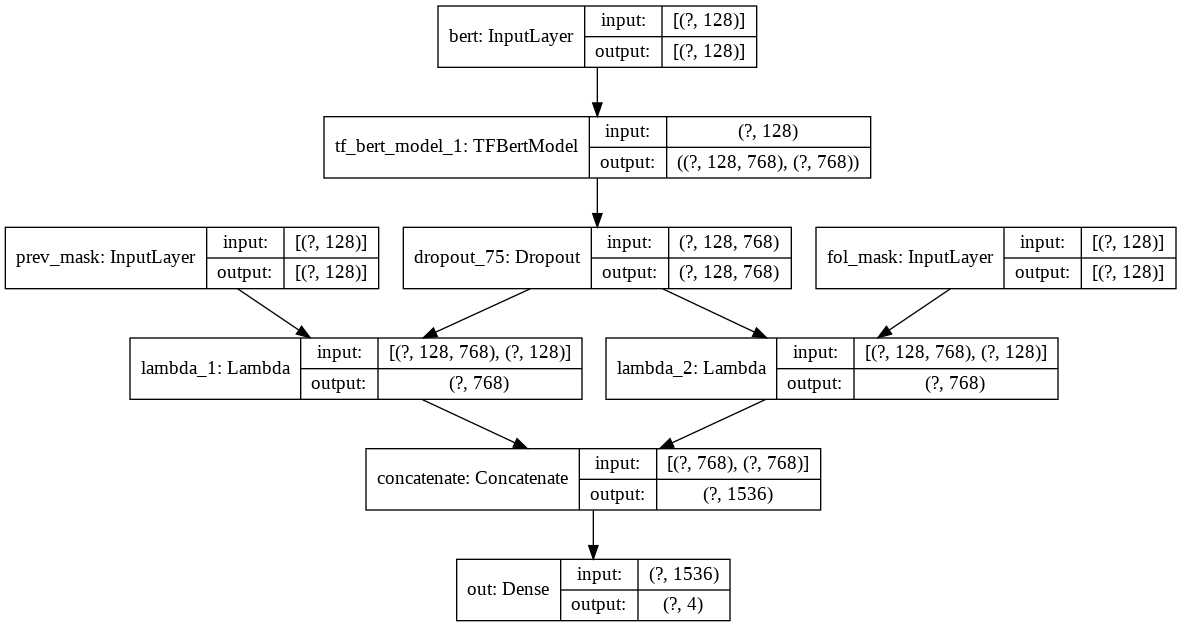

In [ ]:
test_model = sep_token_concat_model(model_name, num_labels)
print(test_model.summary())
tf.keras.utils.plot_model(test_model, show_shapes=True)

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
686/686 [==============================] - 339s 495ms/step - loss: 0.6804 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.3598 - val_sparse_categorical_accuracy: 0.8645
Epoch 2/2
686/686 [==============================] - 337s 491ms/step - loss: 0.3248 - sparse_categorical_accuracy: 0.8843 - val_loss: 0.3200 - val_sparse_categorical_accuracy: 0.8865


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
686/686 [==============================] - 339s 494ms/step - loss: 0.6194 - sparse_categorical_accuracy: 0.7828 - val_loss: 0.3284 - val_sparse_categorical_accuracy: 0.8738
Epoch 2/2
686/686 [==============================] - 336s 490ms/step - loss: 0.2858 - sparse_categorical_accuracy: 0.8996 - val_loss: 0.3156 - val_sparse_categorical_accuracy: 0.8781


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
686/686 [==============================] - 338s 493ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7769 - val_loss: 0.3736 - val_sparse_categorical_accuracy: 0.8654
Epoch 2/2
686/686 [==============================] - 335s 489ms/step - loss: 0.3179 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.3299 - val_sparse_categorical_accuracy: 0.8865
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 128, batch size = 16, epochs = 2
Accuracy: 0.8865, 0.8781, 0.8865
Weighted F-score: 0.8827, 0.8728, 0.8804
Average accuracy: 0.8837, stdev: 0.0040
Average weighted F-score: 0.8786, stdev: 0.0042
              precision    recall  f1-score   support

    negative     0.8447    0.6797    0.7532       128
     neutral     0.9145    0.9559    0.9348       862
       other     0.7937    0.5882    0.6757        85
    positive     0.7544    0.8113    0.7818       106

    accuracy                         0.8865      1181
   macro avg     0.8268  

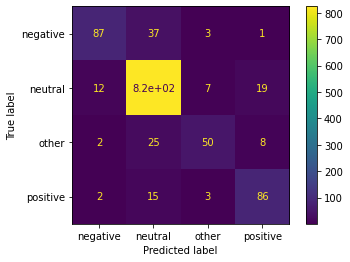

In [ ]:
# Evaluate a model with separate masks for the separation tokens

token_prediction_runs = train_evaluate_custom(
    sep_token_concat_model,
    [tf.constant(whole_train_input), tf.constant(prev_train_mask), tf.constant(fol_train_mask)],
    tf.constant(train_labels),
    [tf.constant(whole_eval_input), tf.constant(prev_eval_mask), tf.constant(fol_eval_mask)],
    tf.constant(eval_labels),
    num_labels,
    3)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(token_prediction_runs, eval_labels)

In [ ]:
# Set up data with sentence id separating context from focus sentence

train_encodings_test = tokenizer(group_train_texts, add_special_tokens=False)
eval_encodings_test = tokenizer(group_eval_texts, add_special_tokens=False)

def add_full_context(ids, labels, encodings, input_size):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    prev_context = [e for l in group[:i] for e in l]
    fol_context = [e for l in group[i+1:] for e in l]
    sentence_size = min(len(group[i]), input_size - 2)
    context_size = max(input_size - sentence_size - 2, 0)
    prev_context = prev_context[len(prev_context)-max(context_size-len(fol_context), context_size//2):]
    fol_context = fol_context[:context_size-len(prev_context)]
    input = [tokenizer.cls_token_id] + prev_context + group[i][:sentence_size] + fol_context + [tokenizer.sep_token_id]
    mask = [0] + [0]*len(prev_context) + [1]*sentence_size + [0]*len(fol_context) + [0]
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

def add_left_context(ids, labels, encodings, input_size):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    prev_context = [e for l in group[:i] for e in l]
    sentence_size = min(len(group[i]), input_size - 2)
    context_size = max(input_size - sentence_size - 2, 0)
    prev_context = prev_context[len(prev_context)-context_size:]
    input = [tokenizer.cls_token_id] + prev_context + group[i][:sentence_size] + [tokenizer.sep_token_id]
    mask = [0] + [0]*len(prev_context) + [1]*sentence_size + [0]
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

def add_left_sep_context(ids, labels, encodings, input_size):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    prev_context = [e for l in group[:i] for e in l]
    sentence_size = min(len(group[i]), input_size - 3)
    context_size = max(input_size - sentence_size - 3, 0)
    prev_context = prev_context[len(prev_context)-context_size:]
    input = [tokenizer.cls_token_id] + prev_context + [tokenizer.sep_token_id] + group[i][:sentence_size] + [tokenizer.sep_token_id]
    mask = [0] + [0]*len(prev_context) + [0] + [1]*sentence_size + [1]
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

def fill_gap(mask):
  first = mask.index(1)
  last = len(mask) - mask[::-1].index(1)
  filled = [0]*len(mask)
  filled[first:last] = [1]*(last-first)
  return filled

def filter_ones(l, mask):
  return [e for e, p in zip(l, mask) if not p]

full_train_context = add_full_context(train_id, train_labels, train_encodings, input_size)
full_eval_context = add_full_context(eval_id, eval_labels, eval_encodings, input_size)

full_train_attention_mask = pad([[1]*len(s) for s in full_train_context[0]], input_size)
full_train_input = pad(full_train_context[0], input_size)
full_train_mask = pad(full_train_context[1], input_size)
full_eval_attention_mask = pad([[1]*len(s) for s in full_eval_context[0]], input_size)
full_eval_input = pad(full_eval_context[0], input_size)
full_eval_mask = pad(full_eval_context[1], input_size)

left_train_context = add_left_context(train_id, train_labels, train_encodings, input_size)
left_eval_context = add_left_context(eval_id, eval_labels, eval_encodings, input_size)

left_train_attention_mask = pad([[1]*len(s) for s in left_train_context[0]], input_size)
left_train_input = pad(left_train_context[0], input_size)
left_train_mask = pad(left_train_context[1], input_size)
left_eval_attention_mask = pad([[1]*len(s) for s in left_eval_context[0]], input_size)
left_eval_input = pad(left_eval_context[0], input_size)
left_eval_mask = pad(left_eval_context[1], input_size)

sentence_train_input_raw = [filter_ones(l, mask) for l, mask in zip(*train_context)]
sentence_train_attention_mask = pad([[1]*len(s) for s in sentence_train_input_raw], input_size)
sentence_train_input = pad(sentence_train_input_raw, input_size)
sentence_train_mask = pad([filter_ones(l, mask) for l, mask in zip([fill_gap(mask) for mask in train_context[1]], train_context[1])], input_size)
sentence_eval_input_raw = [filter_ones(l, mask) for l, mask in zip(*eval_context)]
sentence_eval_attention_mask = pad([[1]*len(s) for s in sentence_eval_input_raw], input_size)
sentence_eval_input = pad(sentence_eval_input_raw, input_size)
sentence_eval_mask = pad([filter_ones(l, mask) for l, mask in zip([fill_gap(mask) for mask in eval_context[1]], eval_context[1])], input_size)

left_sep_train_context = add_left_sep_context(train_id, train_labels, train_encodings, input_size)
left_sep_eval_context = add_left_sep_context(eval_id, eval_labels, eval_encodings, input_size)

left_sep_train_attention_mask = pad([[1]*len(s) for s in left_sep_train_context[0]], input_size)
left_sep_train_input = pad(left_sep_train_context[0], input_size)
left_sep_train_mask = pad(left_sep_train_context[1], input_size)
left_sep_eval_attention_mask = pad([[1]*len(s) for s in left_sep_eval_context[0]], input_size)
left_sep_eval_input = pad(left_sep_eval_context[0], input_size)
left_sep_eval_mask = pad(left_sep_eval_context[1], input_size)

print(train_encodings_test.data['input_ids'][:5])
print(train_encodings_test.data['attention_mask'][:5])
print(train_encodings_test.data['token_type_ids'][:5])

print(full_train_input[:5])
print(full_train_attention_mask[:5])
print(full_train_mask[:5])

print(left_train_input[:5])
print(left_train_attention_mask[:5])
print(left_train_mask[:5])

print(sentence_train_input[:5])
print(sentence_train_attention_mask[:5])
print(sentence_train_mask[:5])

print(left_sep_train_input[:5])
print(left_sep_train_attention_mask[:5])
print(left_sep_train_mask[:5])

t = [tf.constant(full_train_input),
     tf.constant(full_train_attention_mask),
     tf.constant(full_train_mask)]

e = [tf.constant(full_eval_input),
     tf.constant(full_eval_attention_mask),
     tf.constant(full_eval_mask)]

t_left = [tf.constant(left_train_input),
          tf.constant(left_train_attention_mask),
          tf.constant(left_train_mask)]

e_left = [tf.constant(left_eval_input),
          tf.constant(left_eval_attention_mask),
          tf.constant(left_eval_mask)]

t_sentence = [tf.constant(sentence_train_input),
              tf.constant(sentence_train_attention_mask),
              tf.constant(sentence_train_mask)]

e_sentence = [tf.constant(sentence_eval_input),
              tf.constant(sentence_eval_attention_mask),
              tf.constant(sentence_eval_mask)]

t_left_sep = [tf.constant(left_sep_train_input),
              tf.constant(left_sep_train_attention_mask),
              tf.constant(left_sep_train_mask)]

e_left_sep = [tf.constant(left_sep_eval_input),
              tf.constant(left_sep_eval_attention_mask),
              tf.constant(left_sep_eval_mask)]

[[7583, 40130, 16132], [19235, 7583, 4092, 447, 20420, 130, 37279, 25909, 9051, 112], [836, 7154, 2837, 318, 1036, 120, 233, 5812, 465, 4521, 7006, 1229, 3386, 46075, 7859, 108, 112], [1181, 49970, 4581, 2126, 4577, 204, 112], [518, 9880, 120, 6436, 5738, 148, 20631, 120, 190, 24293, 328, 27271, 112]]
[[1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
[[0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[102, 7583, 40130, 16132, 19235, 7583, 4092, 447, 20420, 130, 37279, 25909, 9051, 112, 836, 7154, 2837, 318, 1036, 120, 233, 5812, 465, 4521, 7006, 1229, 3386, 46075, 7859, 108, 112, 1181, 49970, 4581, 2126, 4577, 204, 112, 518, 9880, 120, 6436, 5738, 148, 20631, 120, 190, 24293, 328, 27271, 112, 201, 41240, 50043, 42494, 2625, 148, 1068, 1668, 120, 997, 285, 103, 0, 0, 0

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
686/686 [==============================] - 646s 942ms/step - loss: 0.6357 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.3498 - val_sparse_categorical_accuracy: 0.8645
Epoch 2/8
686/686 [==============================] - 647s 942ms/step - loss: 0.2979 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.3296 - val_sparse_categorical_accuracy: 0.8781
Epoch 3/8
686/686 [==============================] - 647s 943ms/step - loss: 0.1201 - sparse_categorical_accuracy: 0.9622 - val_loss: 0.4023 - val_sparse_categorical_accuracy: 0.8840
Epoch 4/8
686/686 [==============================] - 646s 942ms/step - loss: 0.0567 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.4410 - val_sparse_categorical_accuracy: 0.8823


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_75', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
686/686 [==============================] - 649s 946ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.7600 - val_loss: 0.3630 - val_sparse_categorical_accuracy: 0.8713
Epoch 2/8
686/686 [==============================] - 648s 944ms/step - loss: 0.3034 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.3380 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/8
686/686 [==============================] - 647s 943ms/step - loss: 0.1198 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.4041 - val_sparse_categorical_accuracy: 0.8755


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_113', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
686/686 [==============================] - 649s 946ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.7651 - val_loss: 0.3636 - val_sparse_categorical_accuracy: 0.8662
Epoch 2/8
686/686 [==============================] - 646s 942ms/step - loss: 0.2987 - sparse_categorical_accuracy: 0.8961 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.8823
Epoch 3/8
686/686 [==============================] - 646s 941ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.9598 - val_loss: 0.4538 - val_sparse_categorical_accuracy: 0.8645


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_151']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
686/686 [==============================] - 648s 945ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.7771 - val_loss: 0.3766 - val_sparse_categorical_accuracy: 0.8704
Epoch 2/8
686/686 [==============================] - 647s 943ms/step - loss: 0.2942 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.4049 - val_sparse_categorical_accuracy: 0.8620


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_189']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
686/686 [==============================] - 649s 946ms/step - loss: 0.6477 - sparse_categorical_accuracy: 0.7698 - val_loss: 0.3529 - val_sparse_categorical_accuracy: 0.8747
Epoch 2/8
686/686 [==============================] - 646s 942ms/step - loss: 0.2891 - sparse_categorical_accuracy: 0.8994 - val_loss: 0.3420 - val_sparse_categorical_accuracy: 0.8891
Epoch 3/8
686/686 [==============================] - 646s 941ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.9591 - val_loss: 0.4093 - val_sparse_categorical_accuracy: 0.8781


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_227', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
686/686 [==============================] - 649s 947ms/step - loss: 0.6565 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.4422 - val_sparse_categorical_accuracy: 0.8544
Epoch 2/8
686/686 [==============================] - 647s 943ms/step - loss: 0.2898 - sparse_categorical_accuracy: 0.9008 - val_loss: 0.3223 - val_sparse_categorical_accuracy: 0.8806
Epoch 3/8
686/686 [==============================] - 647s 943ms/step - loss: 0.1146 - sparse_categorical_accuracy: 0.9636 - val_loss: 0.4710 - val_sparse_categorical_accuracy: 0.8645


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_265']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
686/686 [==============================] - 649s 946ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7744 - val_loss: 0.3844 - val_sparse_categorical_accuracy: 0.8696
Epoch 2/8
686/686 [==============================] - 646s 942ms/step - loss: 0.2875 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.3247 - val_sparse_categorical_accuracy: 0.8882
Epoch 3/8
686/686 [==============================] - 646s 942ms/step - loss: 0.1149 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.3878 - val_sparse_categorical_accuracy: 0.8840
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 256, batch size = 16, epochs = 8
Accuracy: 0.8840, 0.8789, 0.8823, 0.8704, 0.8891, 0.8806, 0.8882
Weighted F-score: 0.8822, 0.8722, 0.8760, 0.8566, 0.8836, 0.8755, 0.8840
Average accuracy: 0.8819, stdev: 0.0058
Average weighted F-score: 0.8757, stdev: 0.0089
              precision    recall  f1-score   support

    negative     0.8000    0.5938    0.6816      

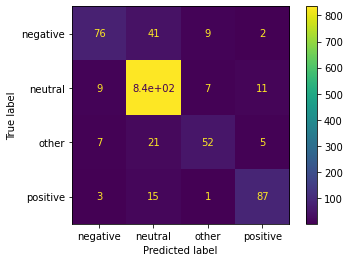

In [ ]:
# Evaluate on data with sentence id separating context from focus sentence

runs = train_evaluate(t, tf.constant(train_labels), e, tf.constant(eval_labels), num_labels, 7)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(runs, eval_labels)

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 633s 923ms/step - loss: 0.5624 - sparse_categorical_accuracy: 0.7969 - val_loss: 0.3462 - val_sparse_categorical_accuracy: 0.8721
Epoch 2/3
686/686 [==============================] - 637s 929ms/step - loss: 0.2376 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.3321 - val_sparse_categorical_accuracy: 0.8738
Epoch 3/3
686/686 [==============================] - 638s 929ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.3858 - val_sparse_categorical_accuracy: 0.8755


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_75', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 639s 932ms/step - loss: 0.5593 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.3445 - val_sparse_categorical_accuracy: 0.8815
Epoch 2/3
686/686 [==============================] - 637s 929ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.9193 - val_loss: 0.3313 - val_sparse_categorical_accuracy: 0.8815


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_113']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 641s 935ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.3491 - val_sparse_categorical_accuracy: 0.8781
Epoch 2/3
686/686 [==============================] - 637s 929ms/step - loss: 0.2396 - sparse_categorical_accuracy: 0.9212 - val_loss: 0.3173 - val_sparse_categorical_accuracy: 0.8874
Epoch 3/3
686/686 [==============================] - 637s 929ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.3463 - val_sparse_categorical_accuracy: 0.8874


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_151', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 640s 933ms/step - loss: 0.5529 - sparse_categorical_accuracy: 0.8049 - val_loss: 0.3612 - val_sparse_categorical_accuracy: 0.8662
Epoch 2/3
686/686 [==============================] - 638s 930ms/step - loss: 0.2349 - sparse_categorical_accuracy: 0.9227 - val_loss: 0.3153 - val_sparse_categorical_accuracy: 0.8772
Epoch 3/3
686/686 [==============================] - 637s 929ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.3580 - val_sparse_categorical_accuracy: 0.8865


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_189']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 639s 932ms/step - loss: 0.5749 - sparse_categorical_accuracy: 0.7907 - val_loss: 0.3313 - val_sparse_categorical_accuracy: 0.8764
Epoch 2/3
686/686 [==============================] - 637s 928ms/step - loss: 0.2296 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.3275 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/3
686/686 [==============================] - 636s 927ms/step - loss: 0.0942 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.3848 - val_sparse_categorical_accuracy: 0.8747


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_227', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 640s 932ms/step - loss: 0.5583 - sparse_categorical_accuracy: 0.8008 - val_loss: 0.3413 - val_sparse_categorical_accuracy: 0.8764
Epoch 2/3
686/686 [==============================] - 638s 930ms/step - loss: 0.2322 - sparse_categorical_accuracy: 0.9209 - val_loss: 0.3264 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/3
686/686 [==============================] - 637s 929ms/step - loss: 0.0897 - sparse_categorical_accuracy: 0.9738 - val_loss: 0.3504 - val_sparse_categorical_accuracy: 0.8857


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['dropout_265', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 641s 934ms/step - loss: 0.5760 - sparse_categorical_accuracy: 0.7879 - val_loss: 0.3532 - val_sparse_categorical_accuracy: 0.8798
Epoch 2/3
686/686 [==============================] - 637s 928ms/step - loss: 0.2378 - sparse_categorical_accuracy: 0.9192 - val_loss: 0.3595 - val_sparse_categorical_accuracy: 0.8671
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 256, batch size = 16, epochs = 3
Accuracy: 0.8755, 0.8815, 0.8874, 0.8865, 0.8789, 0.8857, 0.8798
Weighted F-score: 0.8736, 0.8764, 0.8837, 0.8825, 0.8741, 0.8833, 0.8831
Average accuracy: 0.8822, stdev: 0.0041
Average weighted F-score: 0.8795, stdev: 0.0043
              precision    recall  f1-score   support

    negative     0.7736    0.6406    0.7009       128
     neutral     0.9161    0.9629    0.9389       862
       other     0.7089    0.6588    0.6829        85
    positive     0.8889    0.7547    0.8163       106

    accuracy   

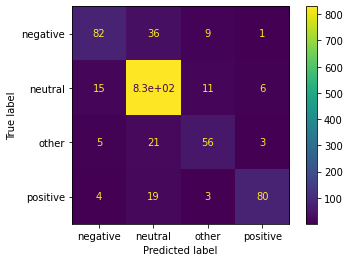

In [ ]:
# Evaluate on data with sentence id separating context from focus sentence and only left context is included

runs = train_evaluate(t_left, tf.constant(train_labels), e_left, tf.constant(eval_labels), num_labels, 7)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(runs, eval_labels)

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_683']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
686/686 [==============================] - 322s 469ms/step - loss: 0.5768 - sparse_categorical_accuracy: 0.7996 - val_loss: 0.3385 - val_sparse_categorical_accuracy: 0.8662
Epoch 2/4
686/686 [==============================] - 320s 466ms/step - loss: 0.2437 - sparse_categorical_accuracy: 0.9185 - val_loss: 0.3296 - val_sparse_categorical_accuracy: 0.8815
Epoch 3/4
686/686 [==============================] - 320s 466ms/step - loss: 0.0952 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.3840 - val_sparse_categorical_accuracy: 0.8848
Epoch 4/4
686/686 [==============================] - 319s 466ms/step - loss: 0.0396 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.4612 - val_sparse_categorical_accuracy: 0.8781


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_721']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
686/686 [==============================] - 322s 470ms/step - loss: 0.5752 - sparse_categorical_accuracy: 0.8028 - val_loss: 0.3377 - val_sparse_categorical_accuracy: 0.8679
Epoch 2/4
686/686 [==============================] - 320s 467ms/step - loss: 0.2399 - sparse_categorical_accuracy: 0.9184 - val_loss: 0.3127 - val_sparse_categorical_accuracy: 0.8857
Epoch 3/4
686/686 [==============================] - 320s 466ms/step - loss: 0.0878 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.4076 - val_sparse_categorical_accuracy: 0.8815


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier', 'dropout_759']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
686/686 [==============================] - 323s 471ms/step - loss: 0.5773 - sparse_categorical_accuracy: 0.7859 - val_loss: 0.3323 - val_sparse_categorical_accuracy: 0.8721
Epoch 2/4
686/686 [==============================] - 320s 467ms/step - loss: 0.2430 - sparse_categorical_accuracy: 0.9170 - val_loss: 0.3258 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/4
686/686 [==============================] - 320s 466ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.4111 - val_sparse_categorical_accuracy: 0.8789
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 128, batch size = 16, epochs = 4
Accuracy: 0.8848, 0.8857, 0.8789
Weighted F-score: 0.8829, 0.8815, 0.8732
Average accuracy: 0.8831, stdev: 0.0030
Average weighted F-score: 0.8792, stdev: 0.0043
              precision    recall  f1-score   support

    negative     0.8137    0.6484    0.7217       128
     neutral     0.9196    0.9548    0.9368       862
     

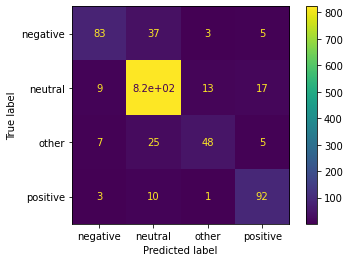

In [ ]:
# Evaluate on data with sentence id separating context from focus sentence and only one sentence of context on both sides

runs = train_evaluate(t_sentence, tf.constant(train_labels), e_sentence, tf.constant(eval_labels), num_labels, 3)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(runs, eval_labels)

In [ ]:
# Set up a model that uses the arithmetic mean of the focus sentence tokens for predictions

from transformers import TFBertModel

def sentence_id_mask_model(model_name, num_labels):
  bert = TFBertModel.from_pretrained(model_name)

  bert_input = tf.keras.layers.Input(shape=(input_size,), dtype='int32', name='bert')
  bert_attention_mask = tf.keras.layers.Input(shape=(input_size,), dtype='int32', name='bert_attention_mask')
  bert_sentence_id_mask = tf.keras.layers.Input(shape=(input_size,), dtype='int32', name='bert_sentence_id_mask')
  mask_input = tf.keras.layers.Input(shape=(input_size,), dtype='float32', name='mask')

  bert_output = bert({'input_ids': bert_input, 'attention_mask': bert_attention_mask, 'token_type_ids': bert_sentence_id_mask})[0]
  bert_dropout = tf.keras.layers.Dropout(0.1)(bert_output)
  masked_mean = tf.keras.layers.Lambda(
      lambda x: tf.math.reduce_sum(tf.math.multiply(x[0], tf.expand_dims(x[1], -1)), axis=[1])
      / tf.math.reduce_sum(x[1])
      )([bert_dropout, mask_input])

  out = tf.keras.layers.Dense(num_labels, activation='softmax', name='out')(masked_mean)

  model = tf.keras.Model(
      inputs=[bert_input, bert_attention_mask, bert_sentence_id_mask, mask_input],
      outputs=[out]
  )

  return model

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_attention_mask (InputLayer [(None, 64)]         0                                            
__________________________________________________________________________________________________
bert (InputLayer)               [(None, 64)]         0                                            
__________________________________________________________________________________________________
bert_sentence_id_mask (InputLay [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 124521984   bert_attention_mask[0][0]        
                                                                 bert[0][0]            

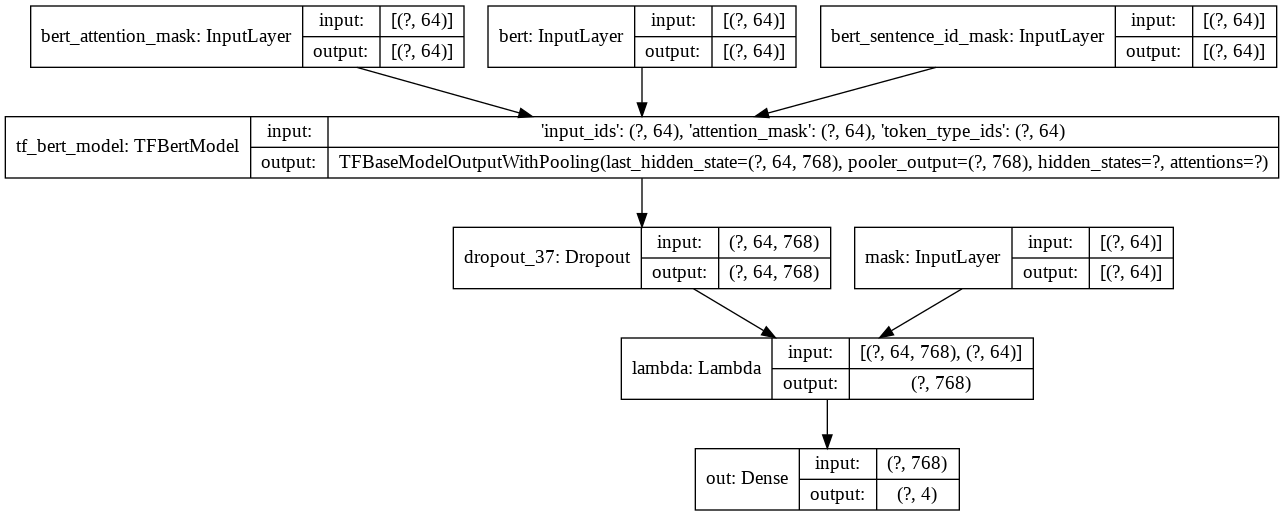

In [ ]:
test_model = sentence_id_mask_model(model_name, num_labels)
print(test_model.summary())
tf.keras.utils.plot_model(test_model, show_shapes=True)

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4
686/686 [==============================] - 639s 931ms/step - loss: 0.7928 - sparse_categorical_accuracy: 0.7749 - val_loss: 0.5627 - val_sparse_categorical_accuracy: 0.8510
Epoch 2/4
686/686 [==============================] - 640s 933ms/step - loss: 0.4940 - sparse_categorical_accuracy: 0.8920 - val_loss: 0.5073 - val_sparse_categorical_accuracy: 0.8662
Epoch 3/4
686/686 [==============================] - 639s 931ms/step - loss: 0.3625 - sparse_categorical_accuracy: 0.9410 - val_loss: 0.5141 - val_sparse_categorical_accuracy: 0.8628
Epoch 4/4
686/686 [==============================] - 639s 932ms/step - loss: 0.2992 - sparse_categorical_accuracy: 0.9670 - val_loss: 0.5111 - val_sparse_categorical_accuracy: 0.8713
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 256, batch size = 16, epochs = 4
Accuracy: 0.8704
Weighted F-score: 0.8649
Average accuracy: 0.8704, stdev: 0.0000
Average weighted F-score: 0.8649, stdev: 0.0000
              pre

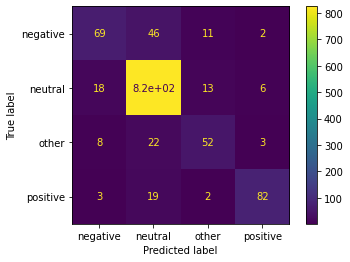

In [ ]:
# Evaluate a model that uses the arithmetic mean of the focus sentence tokens for predictions

token_prediction_runs = train_evaluate_custom(
    sentence_id_mask_model,
    [tf.constant(left_train_input), tf.constant(left_train_attention_mask), tf.constant(pad([[0]*len(l) for l in left_train_context[0]], input_size)), tf.constant(left_train_mask)],
    tf.constant(train_labels),
    [tf.constant(left_eval_input), tf.constant(left_eval_attention_mask), tf.constant(pad([[0]*len(l) for l in left_eval_context[0]], input_size)), tf.constant(left_eval_mask)],
    tf.constant(eval_labels),
    num_labels,
    1)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(token_prediction_runs, eval_labels)

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4
686/686 [==============================] - 121s 177ms/step - loss: 0.7642 - sparse_categorical_accuracy: 0.7794 - val_loss: 0.5523 - val_sparse_categorical_accuracy: 0.8620
Epoch 2/4
686/686 [==============================] - 117s 171ms/step - loss: 0.4547 - sparse_categorical_accuracy: 0.8999 - val_loss: 0.5260 - val_sparse_categorical_accuracy: 0.8628
Epoch 3/4
686/686 [==============================] - 116s 170ms/step - loss: 0.3247 - sparse_categorical_accuracy: 0.9505 - val_loss: 0.4995 - val_sparse_categorical_accuracy: 0.8679
Epoch 4/4
686/686 [==============================] - 116s 169ms/step - loss: 0.2631 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.5405 - val_sparse_categorical_accuracy: 0.8628
Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 64, batch size = 16, epochs = 4
Accuracy: 0.8679
Weighted F-score: 0.8630
Average accuracy: 0.8679, stdev: 0.0000
Average weighted F-score: 0.8630, stdev: 0.0000
              prec

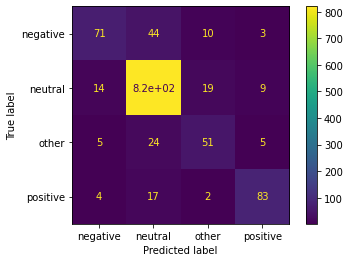

In [ ]:
# Evaluate a model that uses the arithmetic mean of the focus sentence tokens for predictions and sentence IDs for focus sentence separation
token_prediction_runs = train_evaluate_custom(
    sentence_id_mask_model,
    t_left_sep + [tf.constant(left_sep_train_mask)],
    tf.constant(train_labels),
    e_left_sep + [tf.constant(left_sep_eval_mask)],
    tf.constant(eval_labels),
    num_labels,
    1)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(token_prediction_runs, eval_labels)

Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 635s 926ms/step - loss: 0.5654 - sparse_categorical_accuracy: 0.7891 - val_loss: 0.3723 - val_sparse_categorical_accuracy: 0.8721
Epoch 2/3
686/686 [==============================] - 633s 922ms/step - loss: 0.2313 - sparse_categorical_accuracy: 0.9233 - val_loss: 0.3555 - val_sparse_categorical_accuracy: 0.8696
Epoch 3/3
686/686 [==============================] - 633s 923ms/step - loss: 0.0989 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.4249 - val_sparse_categorical_accuracy: 0.8747


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier', 'dropout_75']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 635s 926ms/step - loss: 0.5317 - sparse_categorical_accuracy: 0.8159 - val_loss: 0.3503 - val_sparse_categorical_accuracy: 0.8755
Epoch 2/3
686/686 [==============================] - 633s 922ms/step - loss: 0.2275 - sparse_categorical_accuracy: 0.9260 - val_loss: 0.3745 - val_sparse_categorical_accuracy: 0.8730
Epoch 3/3
686/686 [==============================] - 634s 924ms/step - loss: 0.0946 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.3904 - val_sparse_categorical_accuracy: 0.8798


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['dropout_113', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 636s 927ms/step - loss: 0.5493 - sparse_categorical_accuracy: 0.8029 - val_loss: 0.3420 - val_sparse_categorical_accuracy: 0.8781
Epoch 2/3
686/686 [==============================] - 633s 922ms/step - loss: 0.2217 - sparse_categorical_accuracy: 0.9255 - val_loss: 0.3338 - val_sparse_categorical_accuracy: 0.8755
Epoch 3/3
686/686 [==============================] - 633s 923ms/step - loss: 0.0896 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.4166 - val_sparse_categorical_accuracy: 0.8789


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['dropout_151', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 636s 926ms/step - loss: 0.5405 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.3522 - val_sparse_categorical_accuracy: 0.8789
Epoch 2/3
686/686 [==============================] - 633s 923ms/step - loss: 0.2213 - sparse_categorical_accuracy: 0.9293 - val_loss: 0.3265 - val_sparse_categorical_accuracy: 0.8831
Epoch 3/3
686/686 [==============================] - 632s 921ms/step - loss: 0.0909 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.4068 - val_sparse_categorical_accuracy: 0.8755


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['dropout_189', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 636s 927ms/step - loss: 0.5438 - sparse_categorical_accuracy: 0.8103 - val_loss: 0.3480 - val_sparse_categorical_accuracy: 0.8747
Epoch 2/3
686/686 [==============================] - 633s 922ms/step - loss: 0.2208 - sparse_categorical_accuracy: 0.9263 - val_loss: 0.3897 - val_sparse_categorical_accuracy: 0.8721
Epoch 3/3
686/686 [==============================] - 633s 923ms/step - loss: 0.0894 - sparse_categorical_accuracy: 0.9749 - val_loss: 0.4100 - val_sparse_categorical_accuracy: 0.8789


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier', 'dropout_227']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 636s 928ms/step - loss: 0.5505 - sparse_categorical_accuracy: 0.8038 - val_loss: 0.3262 - val_sparse_categorical_accuracy: 0.8730
Epoch 2/3
686/686 [==============================] - 634s 925ms/step - loss: 0.2228 - sparse_categorical_accuracy: 0.9269 - val_loss: 0.3254 - val_sparse_categorical_accuracy: 0.8772
Epoch 3/3
686/686 [==============================] - 634s 925ms/step - loss: 0.0899 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.3871 - val_sparse_categorical_accuracy: 0.8815


Some layers from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['dropout_265', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
686/686 [==============================] - 636s 928ms/step - loss: 0.5566 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.3674 - val_sparse_categorical_accuracy: 0.8645
Epoch 2/3
686/686 [==============================] - 634s 923ms/step - loss: 0.2251 - sparse_categorical_accuracy: 0.9252 - val_loss: 0.3204 - val_sparse_categorical_accuracy: 0.8798
Epoch 3/3
686/686 [==============================] - 633s 923ms/step - loss: 0.0889 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.3965 - val_sparse_categorical_accuracy: 0.8764
Model: TurkuNLP/bert-base-finnish-uncased-v1, initial learning rate = 2e-05, input size = 256, batch size = 16, epochs = 3
Accuracy: 0.8747, 0.8798, 0.8789, 0.8831, 0.8789, 0.8815, 0.8798
Weighted F-score: 0.8693, 0.8752, 0.8733, 0.8814, 0.8760, 0.8771, 0.8756
Average accuracy: 0.8795, stdev: 0.0024
Average weighted F-score: 0.8754, stdev: 0.0034
              precision    recall  f1-score   support

    negative     0.8095    0.6641    0.7296    

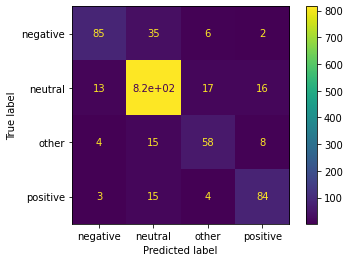

In [ ]:
# Evaluate on tokenized input with left context as sentence 1 and focus sentence as sentence 2

runs = train_evaluate(t_left_sep, tf.constant(train_labels), e_left_sep, tf.constant(eval_labels), num_labels, 7)
print(f"Model: {model_name}, initial learning rate = {init_lr}, input size = {input_size}, batch size = {batch_size_train}, epochs = {epochs}")
print_results(runs, eval_labels)